[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Beginning Classification using BOW!
processing data for BOW model
3 0.3678571428571429
5 0.34571428571428575
7 0.33
9 0.3135714285714286
11 0.2907142857142857
13 0.27


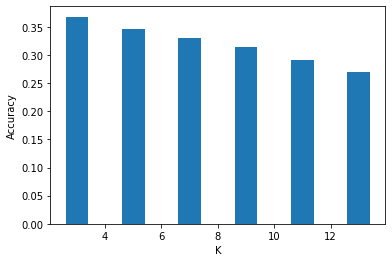

found best k for BOW model, it was 3. starting classifcation!
features: BOW, best_k: 3,  test accuracy: 0.6116666666666667
Beginning Classification using TFIDF!
processing data for TFIDF model
3 0.4892857142857143
5 0.4435714285714286
7 0.4128571428571428
9 0.39357142857142857
11 0.3757142857142857
13 0.37357142857142855


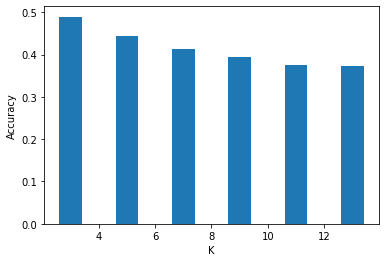

found best k for TFIDF model, it was 3. starting classifcation!
features: TFIDF, best_k: 3,  test accuracy: 0.6783333333333333
Beginning Classification using BERT!
processing data for BERT model


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(None, 512)


In [ ]:
# -*- coding: utf-8 -*-
"""knn_template.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/13PO8rgtfo3dZsYrP3_zT5YNx75Rq97ef

In this HW, we will implement kNN on three different types of features, extracted from the same movie review data used in HW4. The general pipeline is (1) extracting the relevant features, (2) cross validation to find the best k, (3) followed by prediction on the test set and reporting test accuracy.
"""

# imports
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
import random
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig, AutoTokenizer, TFBertModel
import matplotlib.pyplot as plt
import sklearn
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import heapq

tokenizerRegExp = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

"""We will use 4 fold cross validation, and cross validate over the number of nearest neighbors in [3,5,7,9,11,13]"""

kfolds = 4
klist  = [3, 5, 7, 9, 11, 13]
MIN_FREQ = 3
MAX_VOCAB = 768

"""
# The three different features we will use are:
1. BOW representation

In HW4, we implemented NaiveBayes on BOW representation. In this HW, we will use the same features, and classify reviews using kNN classifier.
2.  term-frequency times inverse document-frequency (tf-idf)

We will convert the above BOW matrices into tf-idf features using https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html , and classify reviews using kNN classifier.

3. BERT Embeddings

We will use the pretrained BERT model to extract embeddings for each review, and use these embeddings as input to kNN classifier.
"""

# knn functions
# you are required to implement the following kNN functions

# 2. Generate the i-th fold of k fold validation: used by findBestK below
# Input:
# x is an np array for training data
# y is an np array for labels
# i is an int indicating current fold
# nfolds is the total number of cross validation folds
def fold(x, y, i, nfolds):
    # i \elem [0,nfolds-1]
    # assumes x & y have already been shuffled

    #define start and end of the test set in the ith fold
    sof = i*len(x)//nfolds
    eof = (i+1)*len(x)//nfolds

    x_test = x[sof:eof,:]
    y_test = y[sof:eof]
    x_train = np.concatenate((x[0:sof,:],x[eof:,:]), axis=0)
    y_train = np.concatenate((y[0:sof],y[eof:]), axis=0)

    return x_train, y_train, x_test, y_test

# 3. Classify each testing points based on the training points
# Input
# x_train: a numpy array of training data
# x_test: a numpy array
# k: the number of neighbors to take into account when predicting the label
# Output
# y_predict: a numpy array
def classify(x_train, y_train, x_test, k):
    # your code
    # Euclidean distance as the measurement of distance in KNN
    y_predict = []
    for point in x_test:
        # calc the distances
        dist = []
        for i,datum in enumerate(x_train):
            dist.append((i,np.linalg.norm(point-datum)))
        # select k points with the lowest distances
        dist.sort(key=lambda tup: tup[1])
        # cast votes
        pred = 0
        for j in range(k):
          if y_train[dist[j][0]] == 'pos':
            pred += 1
          elif y_train[dist[j][0]] == 'neg':
            pred += -1
          else:
            raise ValueError('Encountered invalid label in training data')
        # check for majority 
        if pred > 0:
          y_predict.append('pos')
        elif pred < 0:
          y_predict.append('neg')
        
    return y_predict

# 4. Calculate accuracy by comaring with true labels
# Input
# y_predict is a numpy array of 1s and 0s for the class prediction
# y is a numpy array of 1s and 0s for the true class label
def calc_accuracy(y_predict, y):
    c = 0
    for i,q in enumerate(y_predict):
      c += 1 if q == y[i] else 0
    return c/len(y_predict)

# 5. Draw the bar plot of k vs. accuracy
# klist: a list of values of ks
# accuracy_list: a list of accuracies
def barplot(klist, accuracy_list):
    # your code
    # use matplot lib to generate bar plot with K on x axis and cross validation accuracy on y-axis
    plt.bar(klist,accuracy_list)
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.show()
    return 0

# 1. Find the best K
def findBestK(x, y, klist, nfolds):
    kbest = 0
    best_acc = 0
    accuracy_list = []
    for k in klist:
        # get nfolds cross validation accuracy for k neighbors
        # implement fold(x, y, i, nfolds),classify(x_train, y_train, x_test, k) and calc_accuracy(y_predict, y)
        kthfold_acc =[]
        for i in range(nfolds):
            x_train, y_train, x_test, y_test  = fold(x,y,i,nfolds)
            kthfold_acc.append(calc_accuracy(classify(x_train, y_train, x_test, k),y_test))

        accuracy = np.mean(kthfold_acc)
        if accuracy > best_acc:
            kbest = k
            best_acc = accuracy
        accuracy_list.append(accuracy)
        print(k, accuracy)
    # plot cross validation error for each k : implement function barplot(klist, accuracy_list)
    # modify this function according to the HW requirements
    barplot(klist, accuracy_list)
    return kbest

"""# The following sections extract the relevant input features """

# BERT is pretrained with a max length of 512
MAX_LEN = 512
tf.random.set_seed(42)
PRETRAINED_MODEL_ID = "bert-base-uncased"
# Already implemented
def create_inputs_targets(text_examples, tokenizer):
    '''converts inputs into the representation accepted by BERT
    '''
    dataset_dict = {
        "input_ids": [],

        "attention_mask": []
    }

    for item in text_examples:
        encodings = tokenizer(item, return_tensors='tf', max_length = MAX_LEN, truncation = True, pad_to_max_length=True)

        dataset_dict["input_ids"].append((encodings.input_ids))
        dataset_dict["attention_mask"].append((encodings.attention_mask))

    for key in dataset_dict:
        dataset_dict[key] = np.squeeze(np.array(dataset_dict[key]), axis=1)

    x = [
        dataset_dict["input_ids"],

        dataset_dict["attention_mask"]
    ]

    return x

# Copied from HW4 Bert Notebook
def loadRawData(path):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    #Read in the negative reviews for training
    for file in os.listdir(path+'/training_set/neg/'):
        if file.endswith('.txt'):
            with open(path+'/training_set/neg/'+file) as f:
                raw = f.read()
                x_train.append(raw)
                y_train.append('neg')

    #Read in the positive reviews for training
    for file in os.listdir(path + '/training_set/pos/'):
        if file.endswith('.txt'):
            with open(path + '/training_set/pos/' + file) as f:
                raw = f.read()
                x_train.append(raw)
                y_train.append('pos')

    #Read in the negative reviews for testing
    for file in os.listdir(path + '/test_set/neg/'):
        if file.endswith('.txt'):
            with open(path + '/test_set/neg/' + file) as f:
                raw = f.read()
                x_test.append(raw)
                y_test.append('neg')

    #Read in the positive reviews for training
    for file in os.listdir(path + '/test_set/pos/'):
        if file.endswith('.txt'):
            with open(path + '/test_set/pos/' + file) as f:
                raw = f.read()
                x_test.append(raw)
                y_test.append('pos')

    # x_train = np.asarray(x_train)
    # y_train = np.asarray(y_train)
    # x_test = np.asarray(x_test)
    # y_test = np.asarray(y_test)

    shuffle = np.random.permutation(len(x_train))
    x_train1 =[]
    y_train1= []
    for i in shuffle:
        x_train1.append(x_train[i])
        y_train1.append(y_train[i])

    x_train= x_train1
    y_train = y_train1

    return x_train, x_test, y_train, y_test

# Already Implemented
def create_bert():
    '''Creates a model specified by pretrained_model_id

    '''
    # load pretrained BERT model

    # Note that here we use TFBertModel instead of TFBertforSequenceClassification
    model = TFBertModel.from_pretrained(PRETRAINED_MODEL_ID, num_labels = 2 )


    # BERT inputs
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    print(input_ids.shape)
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

    embedding = model(
            input_ids,  attention_mask=attention_mask
        )

    # this returns two embeddings : N X MAX_LEN X 768 (hidden representation for each token) and N X 768 (next sentence prediction token)
    # as we want to represent the entire sentence, we will use the average of the representation for each token in the first output
    # Note that there are other alternative ways  to do this: using the first token (CLS) to represent the entire sentence, or using the
    # next sentence prediction token
    return model



# change the following code to add TFIDF features
def processData(fullDatasetPath, model_type):
  # shuffle train data here, or when loading the train data or as part of kNN cross validation function
  # we will use the bert-base-uncased tokenizer -
  if model_type == 'BERT':
    # load datasets as lists of reviews
    # no preprocessing required!
    # we will use the bert-base-uncased tokenizer -
    XtrainText, XtestText, ytrain, ytest = loadRawData(fullDatasetPath)
    tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_ID)

    # tokenize for bert
    xtrain = create_inputs_targets(XtrainText, tokenizer)

    ytrain = np.array(ytrain)

    xtest = create_inputs_targets(XtestText, tokenizer)

    ytest = np.array(ytest)
    model = create_bert()
    xtrain = np.mean(model.predict(xtrain)[0], axis=1) #we want to represent the entire sentence, we will use the average of the output token representation
    xtest = np.mean(model.predict(xtest)[0], axis=1)

  else:
    # reuse data loading functions from NaiveBayes portions, you can optionally save the BOW matrices and reload here
    # reuse from HW4
    def loadData(path):
      '''
      reads data from the folders
      x_train : [review1, review2, ....., review_n], where each review1 is a list of tokens

      vocabulary is a dictionary: (key: word, value: count)
      '''
      x_train = []
      y_train = []
      vocabulary = []
      x_test = []
      y_test = []
      #Read in the negative reviews for training
      for file in os.listdir(path+'/training_set/neg/'):
          if file.endswith('.txt'):
              with open(path+'/training_set/neg/'+file) as f:
                  raw = f.read().strip()
                  unstemmed_tokens = tokenizerRegExp.tokenize(raw)
                  tokens = [ps.stem(word) for word in unstemmed_tokens]
                  tokens = [word for word in tokens if word not in stop_words]
                  vocabulary+=tokens
                  x_train += [tokens]
                  y_train += ['neg']

      #Read in the positive reviews for training
      for file in os.listdir(path+'/training_set/pos/'):
          if file.endswith('.txt'):
              with open(path+'/training_set/pos/'+file) as f:
                  raw = f.read().strip()
                  unstemmed_tokens = tokenizerRegExp.tokenize(raw)
                  tokens = [ps.stem(word) for word in unstemmed_tokens]
                  tokens = [word for word in tokens if word not in stop_words]
                  vocabulary+=tokens
                  x_train += [tokens]
                  y_train += ['pos']

      #Read in the negative reviews for testing
      for file in os.listdir(path+'/test_set/neg/'):
          if file.endswith('.txt'):
              with open(path+'/test_set/neg/'+file) as f:
                  raw = f.read().strip()
                  unstemmed_tokens = tokenizerRegExp.tokenize(raw)
                  tokens = [ps.stem(word) for word in unstemmed_tokens]
                  tokens = [word for word in tokens if word not in stop_words]
                  vocabulary+=tokens
                  x_test += [tokens]
                  y_test += ['neg']

      #Read in the positive reviews for training
      for file in os.listdir(path+'/test_set/pos/'):
          if file.endswith('.txt'):
              with open(path+'/test_set/pos/'+file) as f:
                  raw = f.read().strip()
                  unstemmed_tokens = tokenizerRegExp.tokenize(raw)
                  tokens = [ps.stem(word) for word in unstemmed_tokens]
                  tokens = [word for word in tokens if word not in stop_words]
                  vocabulary+=tokens
                  x_test += [tokens]
                  y_test += ['pos']

      # Convert vocabulary list to dictionary
      vocab_dict = {}
      for word in vocabulary:
          if word in vocab_dict.keys():
              vocab_dict[word] = vocab_dict[word]+1
          else:
              vocab_dict[word] = 1

      return x_train, x_test, y_train, y_test, vocab_dict

    def getBOWRepresentation(x_train, x_test, vocabulary):
        '''
        converts into Bag of Words representation
        each column is a feature(unique word) from the vocabulary
        x_train_bow : a numpy array with bag of words representation
        '''
        x_train_bow = np.zeros([len(x_train), len(vocabulary)+1])
        for i,review in enumerate(x_train):
            for j,word in enumerate(vocabulary):
                x_train_bow[i][j] = review.count(word)
            

        x_test_bow = np.zeros([len(x_test), len(vocabulary)+1])
        for i,review in enumerate(x_test):
            for j,word in enumerate(vocabulary):
                x_test_bow[i][j] = review.count(word)
           
        return np.array(x_train_bow), np.array(x_test_bow)

    XtrainText, XtestText, ytrain, ytest, vocabulary = loadData(fullDatasetPath)
    vocabulary = dict((word, index) for word, index in vocabulary.items() if \
                   vocabulary[word]>=MIN_FREQ and word in heapq.nlargest(MAX_VOCAB, vocabulary, key=vocabulary.get))
    xtrain, xtest = getBOWRepresentation(XtrainText, XtestText, vocabulary)
    # add TFidF transformer

    if model_type == 'TFIDF':
      # extract TF-IDF features using sklearn helper
      xtrain = sklearn.feature_extraction.text.TfidfTransformer().fit_transform(xtrain).toarray()
      xtest = sklearn.feature_extraction.text.TfidfTransformer().fit_transform(xtest).toarray()

  return xtrain, xtest, ytrain, ytest

def classification_pipeline(path, klist, kfolds, model_type):
  print(f'processing data for {model_type} model')
  xtrain, xtest, ytrain, ytest = processData(path, model_type)
  bestk = findBestK(xtrain, ytrain, klist, kfolds)
  print(f'found best k for {model_type} model, it was {bestk}. starting classifcation!')
  y_pred = classify(xtrain, ytrain, xtest, k=bestk)
  test_acc = calc_accuracy(y_pred, ytest)
  return test_acc, bestk

"""# k-Nearest Neighbor on BOW representation, TF-IDF and BERT embeddings"""

feature_types = ['BOW','TFIDF', 'BERT']
path = '/content/drive/MyDrive/data_sets'
for feature_type in feature_types:
  print(f'Beginning Classification using {feature_type}!')
  test_acc, best_k = classification_pipeline(path, klist, kfolds, feature_type)
  print(f'features: {feature_type}, best_k: {best_k},  test accuracy: {test_acc}')


In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers

Mounted at /content/drive
     |████████████████████████████████| 1.4MB 4.0MB/s 
     |████████████████████████████████| 2.9MB 13.4MB/s 
     |████████████████████████████████| 890kB 44.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ce7147694ee0cf4854afec11ed220a5b80ac9fc3c6552910a8aa934a062e9fef
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
